# Explainable Fault Detection in a Simulated Chemical Process using SHAP

## Introduction
This project explores the use of machine learning models to detect faults in chemical process data, focusing on making the predictions explainable using SHAP values. The dataset used here is the **Tennessee Eastman (TE) dataset**, a widely studied benchmark in process systems engineering for evaluating fault detection and process monitoring methods. The goal of this project is to identify which features contribute to fault classification, aligning with Explainable AI objectives in process engineering.


# Methodology

1. Load process data from a `.dat` file
2. Preprocess the dataset: create fault labels based on index range
3. Train a Random Forest classifier to classify faulty vs non-faulty
4. Use SHAP to understand which input features influenced each prediction
5. Visualize feature importance using SHAP summary plots


In [61]:
# Import libraries for data manipulation and visualization
import pandas as pd                  # For handling data in the table (DataFrame) format
import matplotlib.pyplot as plt      # For creating plots and visualizations
%matplotlib inline                   # Ensures that plot appears right below the code

In [160]:
# Load the dataset from a .dat file (space-seperated values, no headers)
df = pd.read_csv("d00_te.dat", header=None, sep=r'\s+',engine = 'python')   # Space-seperated data is loaded using regex separator and Python engine (safe from warnings)
# Print the shape of the dataset (rows,columns)
print("Shape of dataset:", df.shape)
# display the first 5 rows of the dataset for an overview
df.head()

Shape of dataset: (960, 52)


,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,0.24889,3702.3,4502.7,9.4170,26.996,42.183,2705.2,75.173,120.40,0.33611,...,54.059,24.804,63.269,21.950,40.188,39.461,47.000,47.594,41.384,18.905
1,0.24904,3666.2,4526.0,9.2682,26.710,42.332,2705.5,74.411,120.41,0.33676,...,53.781,24.790,62.171,22.239,40.108,43.710,46.128,47.508,41.658,18.976
2,0.25034,3673.3,4501.3,9.4212,26.842,42.360,2705.3,75.125,120.41,0.33739,...,54.075,24.669,61.585,22.191,40.030,39.480,44.121,47.612,41.721,16.562
3,0.25109,3657.8,4497.8,9.3792,26.528,41.982,2707.3,73.992,120.38,0.33664,...,54.117,24.595,61.561,21.959,40.121,32.848,45.858,47.459,40.836,20.094
4,0.24563,3698.0,4537.4,9.3746,26.736,42.354,2705.3,75.283,120.42,0.32521,...,53.906,24.451,61.388,22.271,39.538,36.682,45.753,47.458,41.727,18.330


The Tennessee Eastman dataset , widely used in fault detection research, has 960 rows and 52 coloumns in total. Here as an overview first 5 rows are displayed. 
Each row represents a sample or observation (for example a moment in time during the process).
Each coloumn represents a different process variable ( such as temperature,p[ressure,concentration etc...)


In [65]:
# Assign meaningful column names to the 52 variables according to the Tennessee Eastman process documentation
# This makes the dataset easier for understanding,use in analysis and modeling
column_names = [
    'A Feed', 'D Feed', 'E Feed', 'A and C Feed', 'Recycle Flow',
    'Reactor Pressure', 'Reactor Level', 'Reactor Temperature', 'Purge Rate',
    'Separator Temperature', 'Separator Level', 'Separator Pressure',
    'Separator Underflow', 'Stripper Level', 'Stripper Pressure',
    'Stripper Underflow', 'Stripper Temperature', 'Stripper Steam Flow',
    'Compressor Work', 'Reactor Cooling Water Outlet Temp',
    'Separator Cooling Water Outlet Temp', 'Valve Position',
    'Stripper Feed Composition A', 'Stripper Feed Composition B', 'Stripper Feed Composition C',
    'Stripper Feed Composition D', 'Stripper Feed Composition E', 'Stripper Feed Composition F',
    'Product Composition A', 'Product Composition B', 'Product Composition C',
    'Product Composition D', 'Product Composition E', 'Product Composition F',
    'Purge Composition A', 'Purge Composition B', 'Purge Composition C',
    'Purge Composition D', 'Purge Composition E', 'Purge Composition F',
    'Recycle Gas Composition A',
    'Feed A Valve', 'Feed D Valve', 'Feed E Valve',
    'A and C Feed Valve', 'Recycle Valve', 'Purge Valve',
    'Separator Pot Valve', 'Stripper Valve', 'Stripper Steam Valve',
    'Reactor Coolant Valve', 'Condensate Valve'
]
# Apply the column names to the DataFrames
df.columns = column_names
# Overview of the first few columns with new column names
df.head()

,A Feed,D Feed,E Feed,A and C Feed,Recycle Flow,Reactor Pressure,Reactor Level,Reactor Temperature,Purge Rate,Separator Temperature,...,Feed D Valve,Feed E Valve,A and C Feed Valve,Recycle Valve,Purge Valve,Separator Pot Valve,Stripper Valve,Stripper Steam Valve,Reactor Coolant Valve,Condensate Valve
0,0.24889,3702.3,4502.7,9.4170,26.996,42.183,2705.2,75.173,120.40,0.33611,...,54.059,24.804,63.269,21.950,40.188,39.461,47.000,47.594,41.384,18.905
1,0.24904,3666.2,4526.0,9.2682,26.710,42.332,2705.5,74.411,120.41,0.33676,...,53.781,24.790,62.171,22.239,40.108,43.710,46.128,47.508,41.658,18.976
2,0.25034,3673.3,4501.3,9.4212,26.842,42.360,2705.3,75.125,120.41,0.33739,...,54.075,24.669,61.585,22.191,40.030,39.480,44.121,47.612,41.721,16.562
3,0.25109,3657.8,4497.8,9.3792,26.528,41.982,2707.3,73.992,120.38,0.33664,...,54.117,24.595,61.561,21.959,40.121,32.848,45.858,47.459,40.836,20.094
4,0.24563,3698.0,4537.4,9.3746,26.736,42.354,2705.3,75.283,120.42,0.32521,...,53.906,24.451,61.388,22.271,39.538,36.682,45.753,47.458,41.727,18.330


In [67]:
# Fault labelling 
df['Fault'] = 0            # Create new column called 'Fault' and label all rows as normal(0)
df.loc[160:, 'Fault'] = 1  # Mark rows from index 160 onward as faulty(1)
df['Fault'].value_counts() # Count how many normal (0) and faulty (1) samples are present

Fault
1    800
0    160
Name: count, dtype: int64

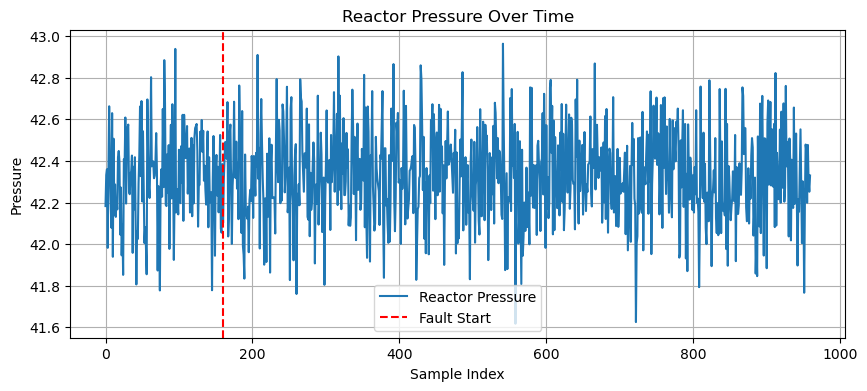

In [69]:
# Visualization of the labelled fault
# Plot the Reactor Pressure to visualize its change over time
plt.figure(figsize=(10, 4))                                # Set the plot size (width=10,height=4) 
# Plot the 'Reactor Pressure' variable from the dataset
plt.plot(df['Reactor Pressure'], label='Reactor Pressure') 
# Add a vertical line at index 160 to show the starting of the fault
plt.axvline(160, color='red', linestyle='--', label='Fault Start')
# Add titles and axis labels
plt.title('Reactor Pressure Over Time')
plt.xlabel('Sample Index') # x-axis represents the sample number or time
plt.ylabel('Pressure')     # y-axis represents the measured reactor pressure
# Show the legend to identify plot lines
plt.legend()
# Add grid lines for better readability
plt.grid(True)
# Display the plot
plt.show()

This plot helps to visualize when the reactor pressure behaviour starts changing due to a fault,aiding in early detection and process monitoring.
This plot gives the idea of how the reactor pressure changes over time from left to right. X-axis represents the time or sample number and Y-axis represents the reactor pressure. The blue line shows the actual reactor pressure values. The red dashed line at the sample index 160 shows the exact point where the fault starts.This helps to decide whether the Reactor Pressure sensor is a useful feature for fault detection.

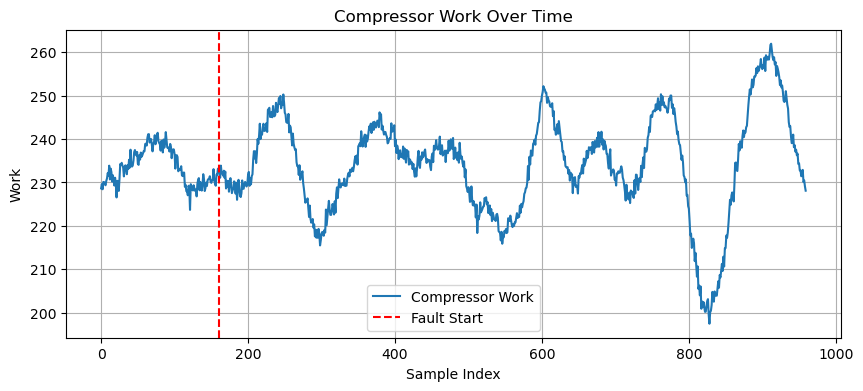

In [71]:
# Plot the Compressor Work to visualize its change over time
plt.figure(figsize=(10, 4))                        # Set the plot size (width=10,height=4) 
# Plot the 'Compressor Work' variable from the dataset
plt.plot(df['Compressor Work'], label='Compressor Work')
# Add a vertical line at index 160 to show the starting of the fault
plt.axvline(160, color='red', linestyle='--', label='Fault Start')
# Add titles and axis labels
plt.title('Compressor Work Over Time')
plt.xlabel('Sample Index')   # x-axis represents the sample number or time
plt.ylabel('Work')           # y-axis represents the measured Compressor Work
# Show the legend to identify plot lines
plt.legend()
# Add grid lines for better readability
plt.grid(True)
# Display the plot
plt.show()


This plot helps to visualize when the Compressor Work of the reactor starts changing due to a fault,aiding in early detection and process monitoring.
This plot gives the idea of how the Compressor Work of the reactor changes over time from left to right. X-axis represents the time or sample number and Y-axis represents the Compressor Work. The blue line shows the actual Compressor Work values. The red dashed line at the sample index 160 shows the exact point where the fault starts.This helps to decide whether the Compressor work is a useful feature for fault detection.

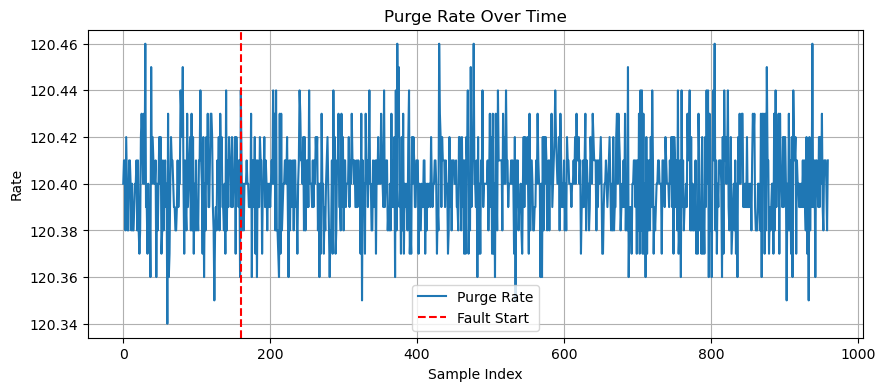

In [73]:
# Plot the Purge Rate to visualize its change over time
plt.figure(figsize=(10, 4))                   # Set the plot size (width=10,height=4)
# Plot the 'Compressor Work' variable from the dataset
plt.plot(df['Purge Rate'], label='Purge Rate')
# Add a vertical line at index 160 to show the starting of the fault
plt.axvline(160, color='red', linestyle='--', label='Fault Start')
# Add titles and axis labels
plt.title('Purge Rate Over Time')
plt.xlabel('Sample Index')             # x-axis represents the sample number or time
plt.ylabel('Rate')                     # y-axis represents the measured Purge Rate
# Show the legend to identify plot lines
plt.legend()
# Add grid lines for better readability
plt.grid(True)
# Display the plot
plt.show()


This plot helps to visualize when the Purge Rate of the reactor starts changing due to a fault,aiding in early detection and process monitoring.
This plot gives the idea of how the Purge Rate  of the reactor changes over time from left to right. X-axis represents the time or sample number and Y-axis represents the Purge Rate. The blue line shows the actual  Purge Rate values. The red dashed line at the sample index 160 shows the exact point where the fault starts.This helps to decide whether the  Purge Rate  is a useful feature for fault detection.

In [74]:
# Import necessary libraries for data analysis and machine learning
import pandas as pd            # For handling data in the table (DataFrame) format
# Split the dataset into testing and training parts
from sklearn.model_selection import train_test_split
# Scale the input features so that they have equal importance
from sklearn.preprocessing import StandardScaler
# A machine learning model that builds multiple decision trees to classify data for fault detection
from sklearn.ensemble import RandomForestClassifier
# Tools to evaluate the model's performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# accuracy_score : Overall prediction accuracy
# confusion_matrix : shows true vs predicted values
# classification_report : gives precision, recall, F-1mscore


In [77]:
# Split the dataset into input features (x) and target labels (y)
X = df.drop(columns=['Fault'])   # x contains all columns except the 'Fault'column
y = df['Fault']                  # y contains the target labels: 0 for normal, 1 for faulty

In [79]:
# Scale the input features 
scaler = StandardScaler()   # Create a scaler object
X_scaled = scaler.fit_transform(X) # Fit to the data and transform it to have mean=0 and std=1

In [81]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42) # This splits 80% for training and 20% for testing
# Print the shape of training and testing sets
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (768, 52)
Test set size: (192, 52)


There are 768 (80% of 960) rows of data for training the model with 52 features for each sample.
Similarly there are 192 ( 20% of 960) rows of data for testing the model with 52 features for each sample.

In [83]:
# Create a Random Forest Classifier with a fixed random seed for reproducibility
model = RandomForestClassifier(random_state=42)
# Train the model using training data
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [84]:
# Install SHAP library (Explainable AI tool) to explain the model's predictions
!pip install shap


In [85]:
# Import libraries for data processing, visualization,and machine learning
import pandas as pd   # For handling data in the table (DataFrame) format
import shap           # For model explainability
import matplotlib.pyplot as plt     # For plotting graphs and visualizations
# Split the dataset into testing and training parts
from sklearn.model_selection import train_test_split
# Scale the input features so that they have equal importance
from sklearn.preprocessing import StandardScaler
# A machine learning model that builds multiple decision trees to classify data for fault detection
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline      # Ensures that plot appears right below the code

In [86]:
#Make predictions on the test data
y_pred = model.predict(X_test)
# Evaluate the models performance using various metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
# Display the confusion matrix to show the True vs Predicted values
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Display the classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9375

Confusion Matrix:
 [[ 16  12]
 [  0 164]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.73        28
           1       0.93      1.00      0.96       164

    accuracy                           0.94       192
   macro avg       0.97      0.79      0.85       192
weighted avg       0.94      0.94      0.93       192



The model achieved an **accuracy of 93.75%** which means most cases are predicted correctly. It caught **164 faulty samples with no misses** but made a few mistakes by misclassifying 12 normal samples as faults, which could be due to some false alarms.

In [88]:
# Create a SHAP explainer for the trained Random Forest Model
explainer = shap.Explainer(model, X_train)
# Compute SHAP values for the test data
shap_values = explainer(X_test)

<Figure size 640x480 with 0 Axes>

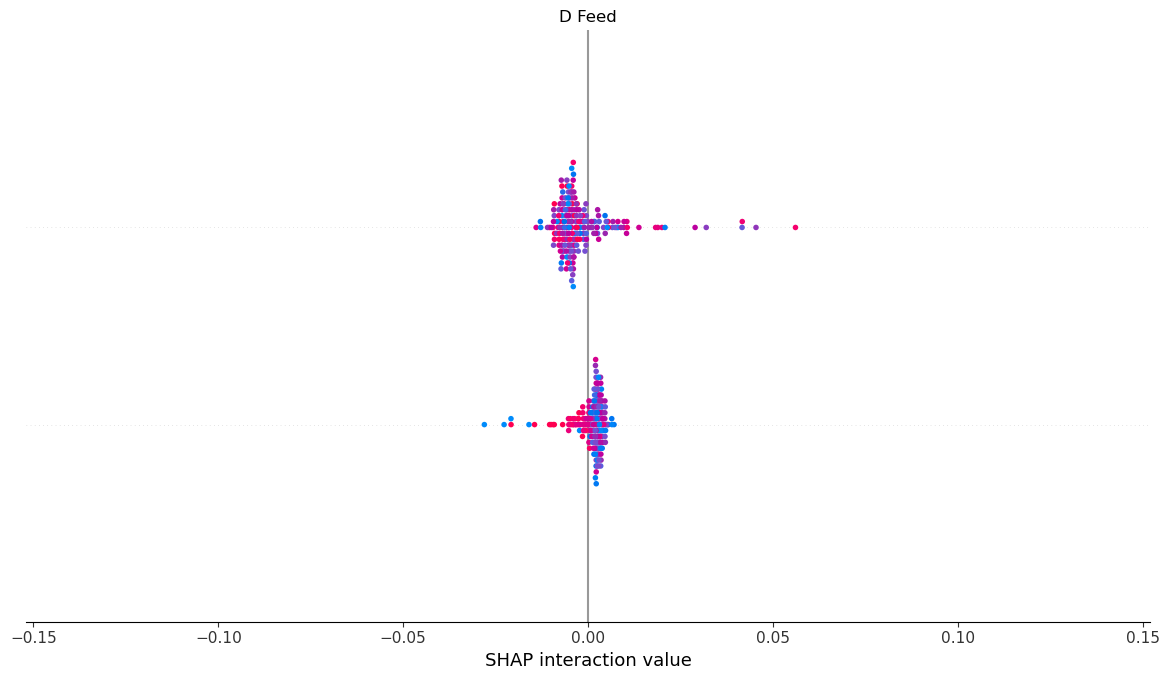

In [89]:
# To visualize feature importance,create a SHAP summary plot
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns)

The SHAP plot above shows how the feature "D feed" contributes to the model's predictions. Each test sample is represented by each dot.
X-axis shows how much "D feed" is pushing the models prediction towards fault or normal.Positive SHAP values push towards predicting a fault and Negative SHAP values push towards predicting a normal one.Red color indicates high feature values and Blue color indicates low feature values.
Here most the values are centered around zero meaning "D feed" has very little influence on the models decisions overall.

# Result
The Tennessee Eastman dataset is used here with 960 rows and 52 coloumns in total.

Reactor Pressure, Compressor Work and Purge Rate plots are plotted and all the three plots show that fault starts from sample index 160.

It is found that there are 768 (80% of 960) rows of data for training the model with 52 features for each sample and there are 192 ( 20% of 960) rows of data for testing the model with 52 features for each sample.

Random classification model is used here and this model has achieved an accuracy of 93.75%
It caught 164 faulty samples with no misses

SHAP analysis gives the idea that some variables like Reactor Pressure had strong influence in the model’s decisions, 
while others like D Feed had only little impact



# Conclusion
In this project a machine learning model is built in a simulated chemical process using the Tennessee Eastman dataset.
Here a Random Forest Classifier model is used. It gave an accuracy of 93.75% and caught 164 faulty samples with no misses.
This is very important in the process industries where missing faults can create great danger.
For understanding the predictions of the model much better, SHAP (SHapley Additive exPlanations) is used here.
SHAP values helps us to find how much each variable such as pressure or flowrate affected the model's prediction.
SHAP plot obtained shows how the feature "D feed" contributes to the model's predictions. Each test sample is represented by each dot.
X-axis shows how much "D feed" is pushing the models prediction towards fault or normal.Positive SHAP values push towards predicting a fault and Negative SHAP values push towards predicting a normal one.Red color indicates high feature values and Blue color indicates low feature values.
Here most the values are centered around zero meaning "D feed" has very little influence on the models decisions overall.
So engineers can focus more on other important variables for better monitoring. 